## Часть 2. Обучение нейросети и расчет ее качества.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import * 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam
import csv
import random
import keras2onnx
import onnx
import tf2onnx

In [4]:
fonts_sample = pd.read_csv('fonts_sample.csv')
fonts_sample = fonts_sample['Font'].tolist()
print('\u001b[38;5;19m', 'Выведем список используемых шрифтов:', '\u001b[0m')
for i in sorted(fonts_sample):
    print('\u001b[38;5;19m', i, '\u001b[0m')

 Выведем список используемых шрифтов: 
 Aguante 
 Alumni Sans Collegiate One Italic 
 Alumni Sans Collegiate One Regular 
 Ambidexter 
 Aref Ruqaa Ink Bold 
 Aref Ruqaa Ink Regular 
 BRASS MONO Bold 
 BRASS MONO Bold Italic 
 BRASS MONO Bold Regular 
 BRASS MONO Italic 
 Better VCR 5.2 
 Ganesha Type Regular 
 Ghastly Panic 
 Realest Extended 
 Tana Uncial SP 


**По результатам первой части иследования получены изображения букв и символов предоставленных шрифтов. Присутствуют малозначимые символы изображения которых могут не идентифицироваться с конкретным шрифтом. Использование их при построении модели приведет к неточностям. Создадим список наименований этих символов и удалим их из данных для обучения.**

In [5]:
excess_index=[]
excess_foto = [410, 488, 566, 644, 732, 972, 973, 987]
for  i in excess_foto:
    excess_index.append(i-1)

In [6]:
excess_foto = [[26,43], [55,69], [132,142], [209,224], [288,298], [300,304], [341,358],  [395,408], [472,486], [550,564], 
               [628,642], [706,717], [723,726], [785,799], [837, 851], [880,883], [892,897], [900,909], [972,985]]
for  i in excess_foto:
    for n in range(i[0]-1, i[1]):
        excess_index.append(n)

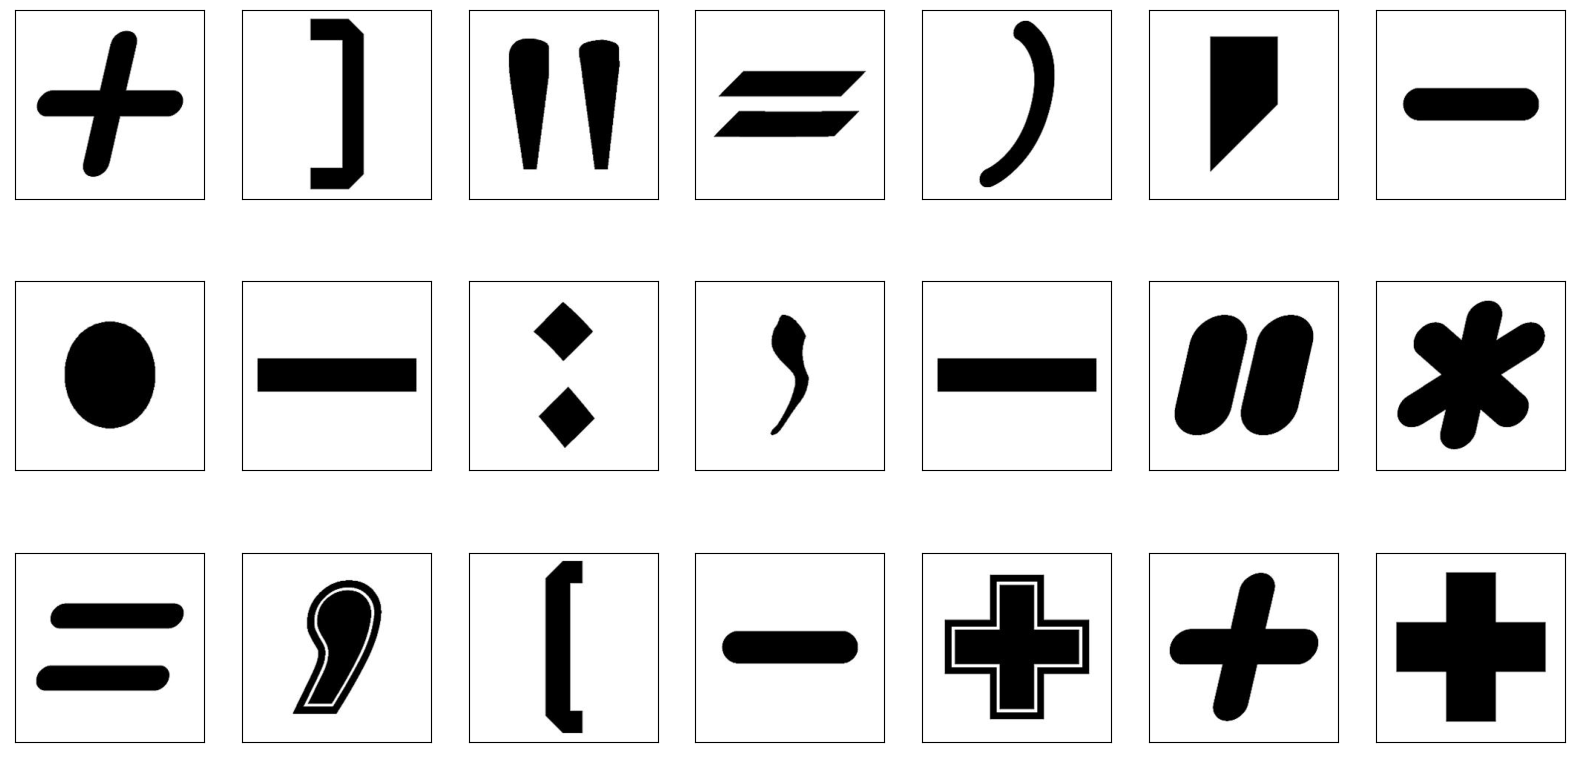

In [7]:
plt.figure(figsize=(20,10))
for i in range(21):
    num = random.choice(excess_index)
    image_path = 'fonts_sample_img/'+str(num+1)+'.jpg'
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap='gray')

In [8]:
df_fonts = pd.read_csv('df_fonts.csv')
display(df_fonts.head(10).style.background_gradient(cmap='Blues', axis=0))

,Letter,Font
0,1.jpg,Aguante
1,2.jpg,Aguante
2,3.jpg,Aguante
3,4.jpg,Aguante
4,5.jpg,Aguante
5,6.jpg,Aguante
6,7.jpg,Aguante
7,8.jpg,Aguante
8,9.jpg,Aguante
9,10.jpg,Aguante


In [9]:
data = df_fonts['Font']
data = data.drop(index=excess_index)
images_list = []
for i in range(0, len(df_fonts)):
    if i not in excess_index:
        img_path = 'fonts_sample_img/'+str(i+1)+'.jpg'
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        images_list.append(img)
    else:
        continue

In [10]:
display(data.value_counts().to_frame().style.background_gradient(cmap='Blues', axis=0))

,Font
Alumni Sans Collegiate One Regular,66
Realest Extended,64
Ambidexter,63
BRASS MONO Bold Regular,62
Alumni Sans Collegiate One Italic,62
BRASS MONO Italic,62
BRASS MONO Bold,62
BRASS MONO Bold Italic,62
Better VCR 5.2,62
Ganesha Type Regular,37


In [11]:
X = np.array(images_list)/255
X = X.astype('float64')

In [12]:
data = data.reset_index()
del data['index']

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore') 
encoder_df = pd.DataFrame(encoder.fit_transform(data[['Font']]).toarray())
data_df = data.join(encoder_df)
data_df.drop('Font', axis=1, inplace= True )

In [14]:
data_new = data_df.values

In [15]:
(X_train, X_test, y_train, y_test) = train_test_split(X, data_new, test_size=0.2, random_state=42)

In [16]:
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

In [17]:
model = tf.keras.models.Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(15, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

In [18]:
history = model.fit(X_train, y_train,
          epochs=100,
          validation_data=(X_test, y_test))

Epoch 1/100
20/20 [==============================] - 12s 592ms/step - loss: 3.5132 - accuracy: 0.1726 - val_loss: 1.7365 - val_accuracy: 0.5223
Epoch 2/100
20/20 [==============================] - 12s 584ms/step - loss: 1.2739 - accuracy: 0.6163 - val_loss: 1.1569 - val_accuracy: 0.6497
Epoch 3/100
20/20 [==============================] - 11s 572ms/step - loss: 0.4427 - accuracy: 0.8895 - val_loss: 1.5598 - val_accuracy: 0.6242
Epoch 4/100
20/20 [==============================] - 11s 554ms/step - loss: 0.1778 - accuracy: 0.9525 - val_loss: 1.1738 - val_accuracy: 0.6943
Epoch 5/100
20/20 [==============================] - 11s 552ms/step - loss: 0.1162 - accuracy: 0.9719 - val_loss: 1.3002 - val_accuracy: 0.6815
Epoch 6/100
20/20 [==============================] - 11s 548ms/step - loss: 0.0146 - accuracy: 0.9986 - val_loss: 1.5004 - val_accuracy: 0.6815
Epoch 7/100
20/20 [==============================] - 11s 554ms/step - loss: 0.0072 - accuracy: 0.9961 - val_loss: 1.3744 - val_accuracy:

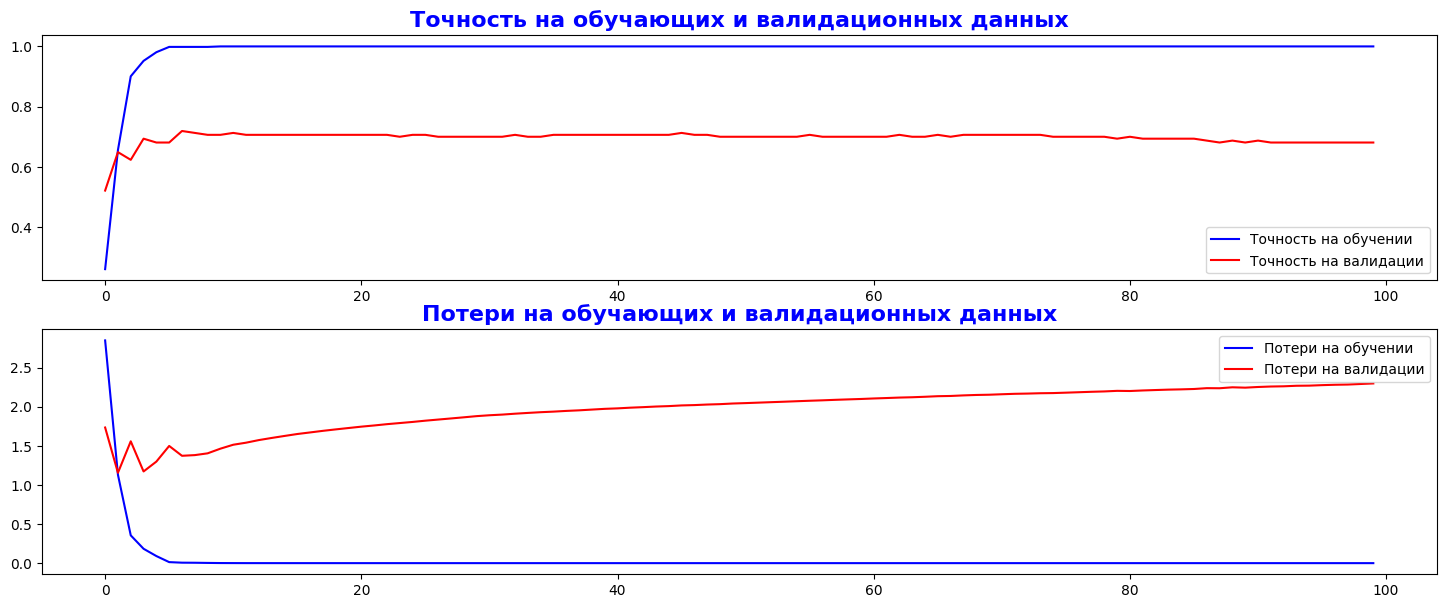

In [19]:
plt.figure(figsize=(18, 7))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label = 'Точность на обучении', color='blue')
plt.plot(history.history['val_accuracy'], label = 'Точность на валидации', color='red')
plt.legend()
plt.title('Точность на обучающих и валидационных данных', fontsize=16, fontweight="bold", color='blue')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label = 'Потери на обучении', color='blue')
plt.plot(history.history['val_loss'], label = 'Потери на валидации', color='red')
plt.legend()
plt.title('Потери на обучающих и валидационных данных', fontsize=16, fontweight="bold", color='blue')
plt.show()

In [20]:
onnx_model, _ = tf2onnx.convert.from_keras(model)
keras2onnx.save_model(onnx_model,  'model_kvant_1.onnx')

In [21]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

In [22]:
with open('data_loss.csv', 'a') as csv_file: 
    writer = csv.writer(csv_file) 
    writer.writerow(loss)

In [23]:
with open('data_val_loss.csv', 'a') as csv_file: 
    writer = csv.writer(csv_file) 
    writer.writerow(val_loss)

In [24]:
print('\u001b[38;5;19m', 'Точность на обучении max (accuracy) =', round(max(accuracy), 2), '\u001b[0m')

 Точность на обучении max (accuracy) = 1.0 


In [25]:
print('\u001b[38;5;19m', 'Точность на валидации max (accuracy) =', round(max(val_accuracy), 2), '\u001b[0m')

 Точность на валидации max (accuracy) = 0.72 


**Можно заметить на графиках, что точность на тренировочном и валидационном наборах данных различаются, и наша модель достигла относительной точности на валидационном наборе данных. Точность на тренировочном наборе достигает практически 100%. В дальнейшем мы будем распознавать текст, состоящий из достаточного количества букв. Если для более половины букв будет распознан одинаковый шрифт, то мы примем это как распознавание всего текста.**